<a href="https://colab.research.google.com/github/lianaling/neural-networks-practice/blob/main/Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformers

[The Annotated Transformer](http://nlp.seas.harvard.edu/annotated-transformer/)
<br />
[A detailed guide to PyTorch’s nn.Transformer() module.](https://towardsdatascience.com/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1)

## Import Dependencies

In [263]:
import os
from os.path import exists
import torch
from torch import nn
from torch.nn.functional import log_softmax, pad
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
import altair as alt
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets as datasets
import spacy
import GPUtil
import warnings
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP

warnings.filterwarnings("ignore")
RUN_EXAMPLES = True

## Define Helper Functions

In [264]:
def is_interactive_notebook():
  return __name__ == "__main__"

def show_example(fn, args=[]):
  if __name__ == "__main__" and RUN_EXAMPLES:
    return fn(*args)

def execute_example(fn, args=[]):
  if __name__ == "__main__" and RUN_EXAMPLES:
    fn(*args)

class DummyOptimizer(torch.optim.Optimizer):
  def __init__(self):
    self.param_groups = [{"lr": 0}]
    None

  def step(self):
    None
  
  def zero_grad(self, set_to_none=False):
    None

class DummyScheduler:
  def step(self):
    None

## Build Model Architecture

Following this architecture

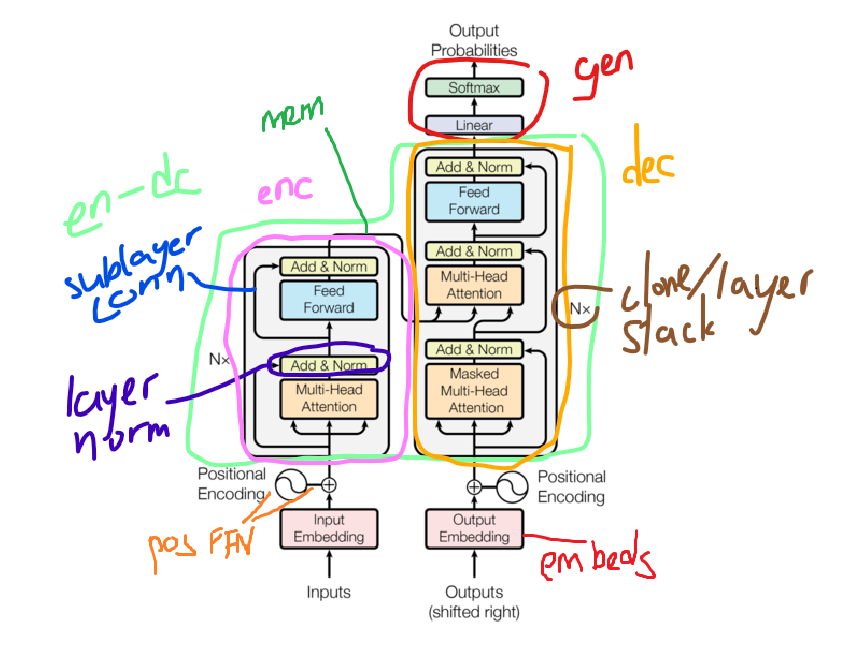

### Encoder-Decoder

Encoder maps input sequence of representations to a sequence of continuous representations `z`. Decoder generates output sequence using `z`. [Auto-regressive](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjm6bia8MT4AhW27TgGHZQkC54QFnoECAQQAw&url=https%3A%2F%2Fwww.investopedia.com%2Fterms%2Fa%2Fautoregressive.asp%23%3A~%3Atext%3DAn%2520AR(1)%2520autoregressive%2520process%2Cno%2520dependence%2520between%2520the%2520terms.&usg=AOvVaw2oqN0WOMnmM6za59bmxSTp) at each time step.

In [265]:
class EncoderDecoder(nn.Module):
  '''Standard encoder-decoder architecture (vanilla)'''
  def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
    super(EncoderDecoder, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.tgt_embed = tgt_embed
    self.generator = generator

  def forward(self, src, tgt, src_mask, tgt_mask):
    '''Take in and process masked src and target sequences'''
    # Pass in encoder output values to decoder
    # Along with the src mask, target and target mask
    return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

  def encode(self, src, src_mask):
    # Encode the src with embeddings and mask with src
    return self.encoder(self.src_embed(src), src_mask)

  def decode(self, memory, src_mask, tgt, tgt_mask):
    # Decode the embedded targets using information from memory and mask tokens
    return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

### Output Generator

In [266]:
class Generator(nn.Module):
  '''Define standard linear + softmax generation step'''

  def __init__(self, d_model, vocab):
    super(Generator, self).__init__()
    # Saving projections into a variable
    self.proj = nn.Linear(d_model, vocab)

  def forward(self, x):
    # Pass projections through softmax layer to get probability distribution
    return log_softmax(self.proj(x), dim=-1)

### Encoder

Encoder with `N = 6` identical layers.

In [267]:
def clones(module, N):
  '''Produce N identical layers'''
  # Stack modules on top of each other
  return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [268]:
class Encoder(nn.Module):
  def __init__(self, layer, N):
    super(Encoder, self).__init__()
    # Each encoder has a bunch of layers followed by the normalisation layer
    self.layers = clones(layer, N)
    self.norm = LayerNorm(layer.size)

  def forward(self, x, mask):
    '''Pass the input and mask through each layer in turn'''
    # Can be optimise using nn.Sequential?
    for layer in self.layers:
      x = layer(x, mask)
    return self.norm(x)

### Layer Normalisation

[Layer Normalization Explained](https://leimao.github.io/blog/Layer-Normalization/)

[Why does adding double.epsilon to a value result in the same value, perfectly equal?](https://stackoverflow.com/questions/27506477/why-does-adding-double-epsilon-to-a-value-result-in-the-same-value-perfectly-eq): it's the smallest double greater than 0 that can be represented as a double

[How to normalize a signal to zero mean and unit variance?](https://stackoverflow.com/questions/8717139/how-to-normalize-a-signal-to-zero-mean-and-unit-variance#:~:text=To%20get%20unit%20variance%2C%20determine,all%20entries%20by%20that%20value.): (zero mean) subtract mean from all the entries; (unit variance) divide all entries by standard deviation.

Zero mean and unit variance:

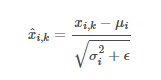

Learnable parameters:

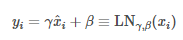

In [269]:
class LayerNorm(nn.Module):
  '''Construct a layernorm module'''
  def __init__(self, features, eps=1e-6):
    super(LayerNorm, self).__init__()
    # Learnable parameters for layer norm
    self.a_2 = nn.Parameter(torch.ones(features))
    self.b_2 = nn.Parameter(torch.zeros(features))
    # Add epsilon for numerical stability in case the denominator becomes zero
    self.eps = eps

  def forward(self, x):
    # Calculate mean and standard deviation, where x = each sample with K elements
    mean = x.mean(-1, keepdim=True)
    std = x.std(-1, keepdim=True)
    # Combine two formulas above
    # Assuming square root no needed because sqrt of epsilon is epsilon?
    return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

### Residual Connection

[What is Residual Connection?](https://towardsdatascience.com/what-is-residual-connection-efb07cab0d55)

In [270]:
class SublayerConnection(nn.Module):
  '''A residual connection followed by a layer norm'''
  def __init__(self, size, dropout):
    super(SublayerConnection, self).__init__()
    self.norm = LayerNorm(size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, sublayer):
    '''Apply residual connection to any sublayer with the same size; note for code simplicity the norm is first as opposed to last'''
    # Let's say F(x) = sublayer(x)
    # Residual connection = F(x) + x
    # Add in dropout then normalisation
    return x + self.dropout(sublayer(self.norm(x)))

### Encoder Layer

Each layer = two sub layers

Sublayer 1 = multi-head self-attention mechanism, sublayer 2 = position-wise fully connected feed-forward network

[Python Anonymous/Lambda Function](https://www.programiz.com/python-programming/anonymous-function)

In [271]:
class EncoderLayer(nn.Module):
  '''Encoder is made up of self-attention and feed-forward'''
  def __init__(self, size, self_attn, feed_forward, dropout):
    super(EncoderLayer, self).__init__()
    self.self_attn = self_attn
    self.feed_forward = feed_forward
    self.sublayer = clones(SublayerConnection(size, dropout), 2)
    self.size = size

  def forward(self, x, mask):
    # Calclulate self-attention and feed-forward values
    x = self.sublayer[0](x, lambda x:self.self_attn(x, x, x, mask))
    return self.sublayer[1](x, self.feed_forward)

### Decoder

A stack of `N = 6` identical layers.

In [272]:
class Decoder(nn.Module):
  '''Generic N layer decoder with masking'''
  def __init__(self, layer, N):
    super(Decoder, self).__init__()
    self.layers = clones(layer, N)
    self.norm = LayerNorm(layer.size)

  def forward(self, x, memory, src_mask, tgt_mask):
    for layer in self.layers:
      x = layer(x, memory, src_mask, tgt_mask)
    return self.norm(x)

### Decoder Layer

In [273]:
class DecoderLayer(nn.Module):
  '''Decoder is made of self-attention, src-attention and feed-forward'''
  def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
    super(DecoderLayer, self).__init__()
    self.size = size
    self.self_attn = self_attn
    self.feed_forward = feed_forward
    self.sublayer = clones(SublayerConnection(size, dropout), 3)

  def forward(self, x, memory, src_mask, tgt_mask):
    # Memory is the buffer output from encoder
    m = memory
    # Calculate self-attention where qkv comes within decoder
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
    # Calculate cross-attention where q from decoder and kv from encoder
    x = self.sublayer[1](x, lambda x: self.self_attn(x, m, m, src_mask))
    # Calculate feed-forward values
    return self.sublayer[2](x, self.feed_forward)

### Masking for Decoder

[`torch.triu`](https://pytorch.org/docs/stable/generated/torch.triu.html)

[`torch.triu() - torch.triu_() - v1.5.0`](https://blog.csdn.net/chengyq116/article/details/106877146)

In [274]:
def subsequent_mask(size):
  '''Mask out subsequent positions'''
  attn_shape = (1, size, size)
  # Only retain up to one diagonal before the main diagonal
  # Allow current word to look at itself
  # torch.uint8 is equivalent to boolean values in a tensor
  subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(torch.uint8)
  return subsequent_mask == 0

In [275]:
def example_mask():
  '''Below the attention mask shows the position each tgt word (row) is allowed to look at (column); 
  words are blocked for attending to future words during training'''
  LS_data = pd.concat(
      [
          pd.DataFrame(
              {
                  "Subsequent Mask": subsequent_mask(20)[0][x, y].flatten(),
                  "Window": y,
                  "Masking": x,
              }
          )
          for y in range(20)
          for x in range(20)
      ]
  )

  return (
      alt.Chart(LS_data)
      .mark_rect()
      .properties(height=250, width=250)
      .encode(
          alt.X("Window:O"),
          alt.Y("Masking:O"),
          alt.Color("Subsequent Mask:Q", scale=alt.Scale(scheme="viridis")),
      )
      .interactive()
  )


show_example(example_mask)

alt.Chart(...)

### Scaled Dot-Product Attention

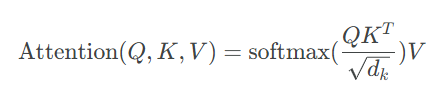

[Masking attention weights in PyTorch](http://juditacs.github.io/2018/12/27/masked-attention.html)

Passing through a softmax function:

| Inputs | Outputs |
|--------|---------|
|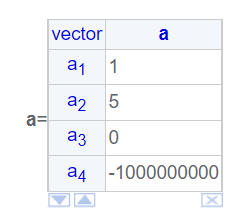 | 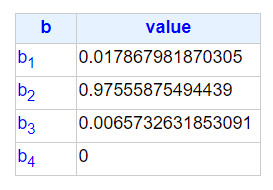 |

In [276]:
def attention(query, key, value, mask=None, dropout=None):
  '''Compute scaled dot-product attention'''
  # Last dimension size
  d_k = query.size(-1)
  # Transpose the second last and last dimension
  scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)

  # Fill elements with -inf (negative infinity) where mask is true
  # All values already have an attention weight
  # For unwanted (masked) values, we cannot just set their weight = 0
  # Because this will cause total probability distribution not sum to 1
  # When passing them into the softmax

  # So, to make sure probabilities for masked tokens are equal to 0
  # Set these padding values to -inf beforehand

  # Due to the softmax formula (see FeedforwardNeuralNetwork.ipynb for details)
  # Generally, larger values of x passed into the softmax function
  # Will give larger output probabilities of y
  # So -inf is theoretically so small that probability output is 0
  if mask is not None:
    scores = scores.masked_fill(mask == 0, -1e9)
  
  # Probabilities of attention scores
  # Why softmax only the last dimension?
  # All pairs of attention scores
  p_attn = scores.softmax(dim=-1)

  # Apply dropout to prevent overfitting
  if dropout is not None:
    p_attn = dropout(p_attn)

  # Multiply attention pairs with values
  return torch.matmul(p_attn, value), p_attn

### Multi-Head Attention

`h = 8` parallel attention layers (heads)

`d_k / h = 64`

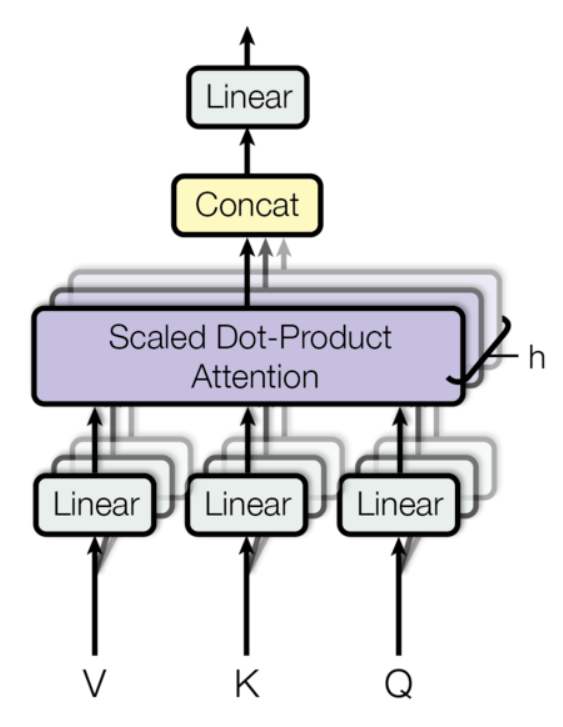

In [277]:
class MultiHeadedAttention(nn.Module):

  def __init__(self, h, d_model, dropout=0.1):
    '''Take in model size and number of heads'''
    super(MultiHeadedAttention, self).__init__()
    # d = dimension
    # d_model must be divisible by h
    assert d_model % h == 0
    # Assume d_v always equals d_k
    # Integer division
    self.d_k = d_model // h
    self.h = h
    self.linears = clones(nn.Linear(d_model, d_model), 4)
    self.attn = None
    self.dropout = nn.Dropout(p=dropout)

  def forward(self, query, key, value, mask=None):
    if mask is not None:
      # Same mask applied to all h heads
      # Add one extra dimension
      mask = mask.unsqueeze(1)

    nbatches = query.size(0)

    # 1) Pass through inputs x into linear layers in batch from d_model => h x d_k
    query, key, value = [
                         lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                         for lin, x in zip(self.linears, (query, key, value))
    ]

    # 2) Apply attention on all the projected vectors in batch
    x, self.attn = attention(
        query, key, value, mask=mask, dropout=self.dropout
    )

    # 3) Concat using a view and apply a final linear
    x = (
        x.transpose(1, 2)
        .contiguous()
        .view(nbatches, -1, self.h * self.d_k)
    )

    del query
    del key
    del value
    return self.linears[-1](x)

Three Applications of attention in Transformer model:

1) Encoder-decoder attention: queries <- previous decoder layer, keys and values <- encoder output; each decoder can attend to all positions in the input sequence (typical mechanism in seq2seq)

2) Encoder self-attention: queries, keys and values <- previous encoder layer; each position in the encoder can attend to all positions in the previous encoder layer

3) Decoder self-attention: queries, keys and values <- previous decoder layer; each position in the decoder can attend to all positions in the previous decoder layer; (additionally) to maintain the auto-regressive property, use `-inf` to mask out unwanted input values in the softmax

### Position-wise Feedforward Neural Networks

Each layer in encoder and decoder contains a FFNN that is applied to each position separately and identically; it has two linear transformations with a ReLU activation in between

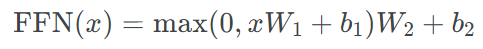

Parameters can differ from layer to layer (two convolutions with kernel size 1)

`d_model = 512` (input and output dimensionality)

`d_ff = 2048` (inner-layer)

In [278]:
class PositionwiseFeedForward(nn.Module):
  '''Implements FFNN equation'''

  def __init__(self, d_model, d_ff, dropout=0.1):
    super(PositionwiseFeedForward, self).__init__()
    self.w_1 = nn.Linear(d_model, d_ff)
    self.w_2 = nn.Linear(d_ff, d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    return self.w_2(self.dropout(self.w_1(x).relu()))

### Embeddings and Softmax

Use learned embeddings to convert input and output tokens to `d_model`; use softmax to generate probabilties; two embedding layers and pre-softmax linear transformation share same weight matrix; these weights are multiplied by `sqrt(d_model)`

In [279]:
class Embeddings(nn.Module):
  def __init__(self, d_model, vocab):
    super(Embeddings, self).__init__()
    self.lut = nn.Embedding(vocab, d_model)
    self.d_model = d_model

  def forward(self, x):
    return self.lut(x) * math.sqrt(self.d_model)

### Positional Encoding

Positional encodings have same dimension as `d_model` to sum both of them

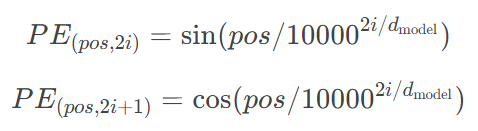

`pos` = position

`i` = dimension

Each dimension of the positional encoding corresponds to a sinusoid

Wavelengths progress from `2 pi` to `10000 * 2 pi`

Hypothesis: this function will help model to learn using relative positions (fixed offset can be added to the original function)

Apply dropout to sums of embeddings and positional encodings in both encoder and decoder stacks

[`register_buffer(name, tensor, persistent=True)`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)

In [280]:
class PositionalEncoding(nn.Module):
  
  def __init__(self, d_model, dropout, max_len=5000):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p=dropout)

    # Calculate positional encodings in log space
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len).unsqueeze(1)
    div_term = torch.exp(
        torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
    )
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0)
    # Register a buffer that isn't a parameter
    self.register_buffer("pe", pe)

  def forward(self, x):
    x = x + self.pe[:, : x.size(1)].requires_grad_(False)
    return self.dropout(x)

In [281]:
def example_positional():
  '''Add in a sine wave based on position'''
  pe = PositionalEncoding(20, 0)
  y = pe.forward(torch.zeros(1, 100, 20))

  data = pd.concat(
      [
          pd.DataFrame(
              {
                  "embedding": y[0, :, dim],
                  "dimension": dim,
                  "position": list(range(100)),
              }
          )
          for dim in [4, 5, 6, 7]
      ]
  )

  return (
      alt.Chart(data)
      .mark_line()
      .properties(width=800)
      .encode(x="position", y="embedding", color="dimension:N")
      .interactive()
  )


show_example(example_positional)

alt.Chart(...)

### Full Model

In [282]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
  '''Construct model from hyperparameters'''
  c = copy.deepcopy
  attn = MultiHeadedAttention(h, d_model)
  ff = PositionwiseFeedForward(d_model, d_ff, dropout)
  position = PositionalEncoding(d_model, dropout)
  model = EncoderDecoder(
      Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
      Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
      nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
      nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
      Generator(d_model, tgt_vocab),
  )

  for p in model.parameters():
    if p.dim() > 1:
      nn.init.xavier_uniform_(p)

  return model

### Inference

In [283]:
def inference_test():
  test_model = make_model(11, 11, 2)
  test_model.eval()
  src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
  src_mask = torch.ones(1, 1, 10)

  memory = test_model.encode(src, src_mask)
  ys = torch.zeros(1, 1).type_as(src)

  for i in range(9):
      out = test_model.decode(
          memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
      )
      prob = test_model.generator(out[:, -1])
      _, next_word = torch.max(prob, dim=1)
      next_word = next_word.data[0]
      ys = torch.cat(
          [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
      )

  print("Example Untrained Model Prediction:", ys)


def run_tests():
  for _ in range(10):
      inference_test()


show_example(run_tests)

Example Untrained Model Prediction: tensor([[0, 1, 5, 8, 2, 3, 5, 2, 3, 5]])
Example Untrained Model Prediction: tensor([[0, 8, 8, 8, 8, 8, 8, 8, 8, 8]])
Example Untrained Model Prediction: tensor([[ 0,  1,  8,  4, 10,  8,  4,  4,  4,  4]])
Example Untrained Model Prediction: tensor([[0, 9, 3, 3, 3, 6, 5, 8, 3, 7]])
Example Untrained Model Prediction: tensor([[0, 7, 3, 5, 9, 3, 5, 4, 5, 9]])
Example Untrained Model Prediction: tensor([[ 0,  6,  6,  2, 10,  2, 10, 10, 10, 10]])
Example Untrained Model Prediction: tensor([[0, 1, 4, 1, 4, 1, 4, 1, 4, 7]])
Example Untrained Model Prediction: tensor([[ 0, 10, 10,  5, 10,  5,  5,  5, 10,  5]])
Example Untrained Model Prediction: tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
Example Untrained Model Prediction: tensor([[0, 9, 9, 9, 9, 9, 9, 8, 4, 8]])


# Using Pytorch's `nn.Transformer`

In [284]:
import torch
import torch.nn as nn
import torch.optim as optim

import math
import numpy as np

In [292]:
class Transformer(nn.Module):
  def __init__(
      self,
      num_tokens,
      dim_model,
      num_heads,
      num_encoder_layers,
      num_decoder_layers,
      dropout_p,
  ):
    super().__init__()

    self.model_type = "Transformer"
    self.dim_model = dim_model

    # Layers
    self.positional_encoder = PositionalEncoding(
        dim_model=dim_model, dropout_p=dropout_p, max_len=5000
    )
    self.embedding = nn.Embedding(num_tokens, dim_model)
    self.transformer = nn.Transformer(
        d_model=dim_model,
        nhead=num_heads,
        num_encoder_layers=num_encoder_layers,
        num_decoder_layers=num_decoder_layers,
        dropout=dropout_p
    )

    self.out = nn.Linear(dim_model, num_tokens)

  def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
    # Src size must be (batch_size, src sequence length)
    # Tgt size must be (batch_size, tgt sequence length)

    # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
    src = self.embedding(src) * math.sqrt(self.dim_model)
    tgt = self.embedding(tgt) * math.sqrt(self.dim_model)
    src = self.positional_encoder(src)
    tgt = self.positional_encoder(tgt)

    # Permute to obtain size (sequence length, batch_size, dim_model)
    src = src.permute(1, 0, 2)
    tgt = tgt.permute(1, 0, 2)

    # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
    transformer_out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask)
    out = self.out(transformer_out)

    return out

  def get_tgt_mask(self, size) -> torch.tensor:
    # Generates a square matrix where the each row allows one word more to be seen
    mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
    mask = mask.float()
    mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
    mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
    
    # EX for size=5:
    # [[0., -inf, -inf, -inf, -inf],
    #  [0.,   0., -inf, -inf, -inf],
    #  [0.,   0.,   0., -inf, -inf],
    #  [0.,   0.,   0.,   0., -inf],
    #  [0.,   0.,   0.,   0.,   0.]]
    
    return mask
    
  def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
    # If matrix = [1,2,3,0,0,0] where pad_token=0, the result mask is
    # [False, False, False, True, True, True]
    return (matrix == pad_token)

In [293]:
class PositionalEncoding(nn.Module):

  def __init__(self, dim_model, dropout_p, max_len):
    super().__init__()

    self.dropout = nn.Dropout(dropout_p)

    pos_encoding = torch.zeros(max_len, dim_model)
    positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1)
    div_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model)

    pos_encoding[:, 0::2] = torch.sin(positions_list * div_term)
    pos_encoding[:, 1::2] = torch.cos(positions_list * div_term)

    pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
    self.register_buffer("pos_encoding", pos_encoding)

  def forward(self, token_embedding):
    # Residual connection + pos encoding
    return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])

In [294]:
def generate_random_data(n):
  SOS_token = np.array([2])
  EOS_token = np.array([3])
  length = 8

  data = []

  # 1,1,1,1,1,1 -> 1,1,1,1,1
  for i in range(n // 3):
      X = np.concatenate((SOS_token, np.ones(length), EOS_token))
      y = np.concatenate((SOS_token, np.ones(length), EOS_token))
      data.append([X, y])

  # 0,0,0,0 -> 0,0,0,0
  for i in range(n // 3):
      X = np.concatenate((SOS_token, np.zeros(length), EOS_token))
      y = np.concatenate((SOS_token, np.zeros(length), EOS_token))
      data.append([X, y])

  # 1,0,1,0 -> 1,0,1,0,1
  for i in range(n // 3):
      X = np.zeros(length)
      start = np.random.randint(0, 1)

      X[start::2] = 1

      y = np.zeros(length)
      if X[-1] == 0:
          y[::2] = 1
      else:
          y[1::2] = 1

      X = np.concatenate((SOS_token, X, EOS_token))
      y = np.concatenate((SOS_token, y, EOS_token))

      data.append([X, y])

  np.random.shuffle(data)

  return data


def batchify_data(data, batch_size=16, padding=False, padding_token=-1):
  batches = []
  for idx in range(0, len(data), batch_size):
      # We make sure we dont get the last bit if its not batch_size size
      if idx + batch_size < len(data):
          # Here you would need to get the max length of the batch,
          # and normalize the length with the PAD token.
          if padding:
              max_batch_length = 0

              # Get longest sentence in batch
              for seq in data[idx : idx + batch_size]:
                  if len(seq) > max_batch_length:
                      max_batch_length = len(seq)

              # Append X padding tokens until it reaches the max length
              for seq_idx in range(batch_size):
                  remaining_length = max_bath_length - len(data[idx + seq_idx])
                  data[idx + seq_idx] += [padding_token] * remaining_length

          batches.append(np.array(data[idx : idx + batch_size]).astype(np.int64))

  print(f"{len(batches)} batches of size {batch_size}")

  return batches


train_data = generate_random_data(9000)
val_data = generate_random_data(3000)

train_dataloader = batchify_data(train_data)
val_dataloader = batchify_data(val_data)

562 batches of size 16
187 batches of size 16


In [295]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Transformer(
    num_tokens=4, dim_model=8, num_heads=2, num_encoder_layers=3, num_decoder_layers=3, dropout_p=0.1
).to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

In [296]:
def train_loop(model, opt, loss_fn, dataloader):
  """
  Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
  Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
  """
  
  model.train()
  total_loss = 0
  
  for batch in dataloader:
      X, y = batch[:, 0], batch[:, 1]
      X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)

      # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
      y_input = y[:,:-1]
      y_expected = y[:,1:]
      
      # Get mask to mask out the next words
      sequence_length = y_input.size(1)
      tgt_mask = model.get_tgt_mask(sequence_length).to(device)

      # Standard training except we pass in y_input and tgt_mask
      pred = model(X, y_input, tgt_mask)

      # Permute pred to have batch size first again
      pred = pred.permute(1, 2, 0)      
      loss = loss_fn(pred, y_expected)

      opt.zero_grad()
      loss.backward()
      opt.step()
  
      total_loss += loss.detach().item()
      
  return total_loss / len(dataloader)

In [297]:
def validation_loop(model, loss_fn, dataloader):
  """
  Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
  Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
  """
  
  model.eval()
  total_loss = 0
  
  with torch.no_grad():
      for batch in dataloader:
          X, y = batch[:, 0], batch[:, 1]
          X, y = torch.tensor(X, dtype=torch.long, device=device), torch.tensor(y, dtype=torch.long, device=device)

          # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
          y_input = y[:,:-1]
          y_expected = y[:,1:]
          
          # Get mask to mask out the next words
          sequence_length = y_input.size(1)
          tgt_mask = model.get_tgt_mask(sequence_length).to(device)

          # Standard training except we pass in y_input and src_mask
          pred = model(X, y_input, tgt_mask)

          # Permute pred to have batch size first again
          pred = pred.permute(1, 2, 0)      
          loss = loss_fn(pred, y_expected)
          total_loss += loss.detach().item()
      
  return total_loss / len(dataloader)

In [298]:
def fit(model, opt, loss_fn, train_dataloader, val_dataloader, epochs):
  """
  Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
  Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
  """
  
  # Used for plotting later on
  train_loss_list, validation_loss_list = [], []
  
  print("Training and validating model")
  for epoch in range(epochs):
      print("-"*25, f"Epoch {epoch + 1}","-"*25)
      
      train_loss = train_loop(model, opt, loss_fn, train_dataloader)
      train_loss_list += [train_loss]
      
      validation_loss = validation_loop(model, loss_fn, val_dataloader)
      validation_loss_list += [validation_loss]
      
      print(f"Training loss: {train_loss:.4f}")
      print(f"Validation loss: {validation_loss:.4f}")
      print()
      
  return train_loss_list, validation_loss_list
  
train_loss_list, validation_loss_list = fit(model, opt, loss_fn, train_dataloader, val_dataloader, 10)


Training and validating model
------------------------- Epoch 1 -------------------------
Training loss: 0.5465
Validation loss: 0.3229

------------------------- Epoch 2 -------------------------
Training loss: 0.3247
Validation loss: 0.2651

------------------------- Epoch 3 -------------------------
Training loss: 0.2828
Validation loss: 0.2250

------------------------- Epoch 4 -------------------------
Training loss: 0.2567
Validation loss: 0.1954

------------------------- Epoch 5 -------------------------
Training loss: 0.2389
Validation loss: 0.1775

------------------------- Epoch 6 -------------------------
Training loss: 0.2233
Validation loss: 0.1608

------------------------- Epoch 7 -------------------------
Training loss: 0.2063
Validation loss: 0.1339

------------------------- Epoch 8 -------------------------
Training loss: 0.1933
Validation loss: 0.1264

------------------------- Epoch 9 -------------------------
Training loss: 0.1808
Validation loss: 0.1232

-------

In [299]:
def predict(model, input_sequence, max_length=15, SOS_token=2, EOS_token=3):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    model.eval()
    
    y_input = torch.tensor([[SOS_token]], dtype=torch.long, device=device)

    num_tokens = len(input_sequence[0])

    for _ in range(max_length):
        # Get source mask
        tgt_mask = model.get_tgt_mask(y_input.size(1)).to(device)
        
        pred = model(input_sequence, y_input, tgt_mask)
        
        next_item = pred.topk(1)[1].view(-1)[-1].item() # num with highest probability
        next_item = torch.tensor([[next_item]], device=device)

        # Concatenate previous input with predicted best word
        y_input = torch.cat((y_input, next_item), dim=1)

        # Stop if model predicts end of sentence
        if next_item.view(-1).item() == EOS_token:
            break

    return y_input.view(-1).tolist()
  
  
# Here we test some examples to observe how the model predicts
examples = [
    torch.tensor([[2, 0, 0, 0, 0, 0, 0, 0, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 1, 1, 1, 1, 1, 1, 1, 1, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 1, 0, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 0, 1, 0, 1, 0, 1, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 3]], dtype=torch.long, device=device)
]

for idx, example in enumerate(examples):
    result = predict(model, example)
    print(f"Example {idx}")
    print(f"Input: {example.view(-1).tolist()[1:-1]}")
    print(f"Continuation: {result[1:-1]}")
    print()

Example 0
Input: [0, 0, 0, 0, 0, 0, 0, 0]
Continuation: [0, 0, 0, 0, 0, 0, 0, 0]

Example 1
Input: [1, 1, 1, 1, 1, 1, 1, 1]
Continuation: [1, 1, 1, 1, 1, 1, 1, 1]

Example 2
Input: [1, 0, 1, 0, 1, 0, 1, 0]
Continuation: [1, 0, 1, 0, 1, 0, 1, 0]

Example 3
Input: [0, 1, 0, 1, 0, 1, 0, 1]
Continuation: [1, 0, 1, 0, 1, 0, 1, 0]

Example 4
Input: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Continuation: [1, 0, 1, 0, 1, 0, 1, 0]

Example 5
Input: [0, 1]
Continuation: [1, 0, 1, 0, 1, 0, 1, 0]

